In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [22]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [23]:
dailyData = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

## Data Summary

In [24]:
dailyData.shape

(10886, 12)

In [25]:
dailyData.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [26]:
dailyData.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

## Feature Engineering

In [27]:
# Creating New Columns From "Datetime" Column
dailyData["date"] = dailyData.datetime.apply(lambda x: x.split()[0])
dailyData["hour"] = dailyData.datetime.apply(lambda x: x.split()[1].split(":")[0])
dailyData["weekday"] = dailyData.date.apply(
    lambda dateString: calendar.day_name[
        datetime.strptime(dateString, "%Y-%m-%d").weekday()
    ]
)
dailyData["month"] = dailyData.date.apply(
    lambda dateString: calendar.month_name[
        datetime.strptime(dateString, "%Y-%m-%d").month
    ]
)
dailyData["season"] = dailyData.season.map(
    {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
)
dailyData["weather"] = dailyData.weather.map(
    {
        1: " Clear + Few clouds + Partly cloudy + Partly cloudy",
        2: " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ",
        3: " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
        4: " Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog ",
    }
)

In [28]:
# Coercing To Category Type
categoryVariableList = ["hour", "weekday", "month", "weather", "holiday", "workingday"]

for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [29]:
# Dropping Unnecessary Columns
dailyData = dailyData.drop(["datetime"], axis=1)

<AxesSubplot:xlabel='variableType', ylabel='count'>

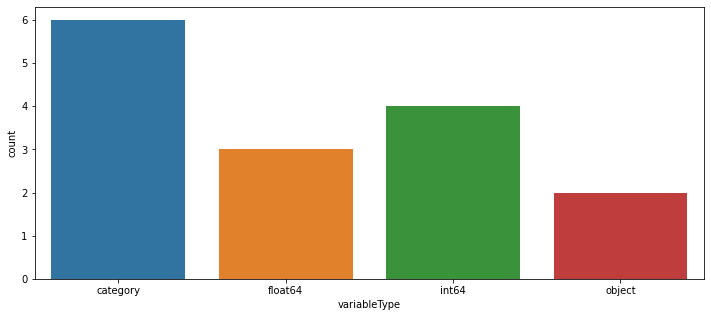

In [37]:
# simple visualization of variables datatype cound
typesCountSerie = dailyData.dtypes.value_counts()

# format columns as arrays of either strings or integers
# typeNames are easier to sort as array of `string` rather than an array of `dtype`
typeNamesColumn = list(map(lambda t: t.name , typesCountSerie.index.values));
typeCountColumn = typesCountSerie.values

# create an initial dataframe, with multiple occurences of the same "variableType"
intialDataTypeDf = pd.DataFrame({
    "variableType": typeNamesColumn, 
    "count": typeCountColumn
})

# Group initial data frame by "variableType", 
# then reset_index to have a proper dataframe
groupedDataTypeDf = intialDataTypeDf.groupby(['variableType']).sum()[['count']].reset_index()

# Plot as expect
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
sn.barplot(data=groupedDataTypeDf, x="variableType",y="count", ax=ax)

## Missing Values Analysis

<AxesSubplot:>

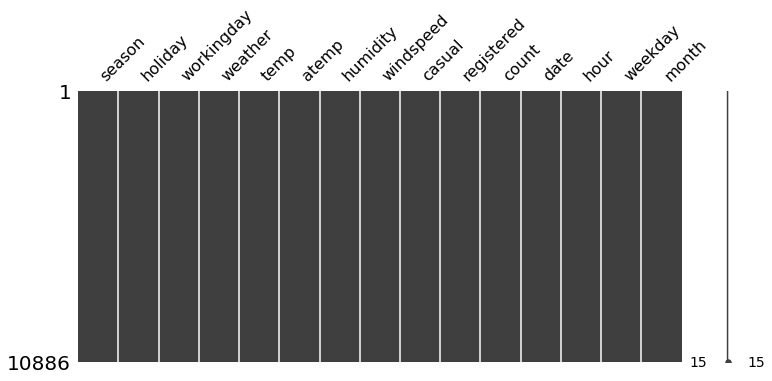

In [38]:
msno.matrix(dailyData, figsize=(12, 5))

## Outliers Analysis

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

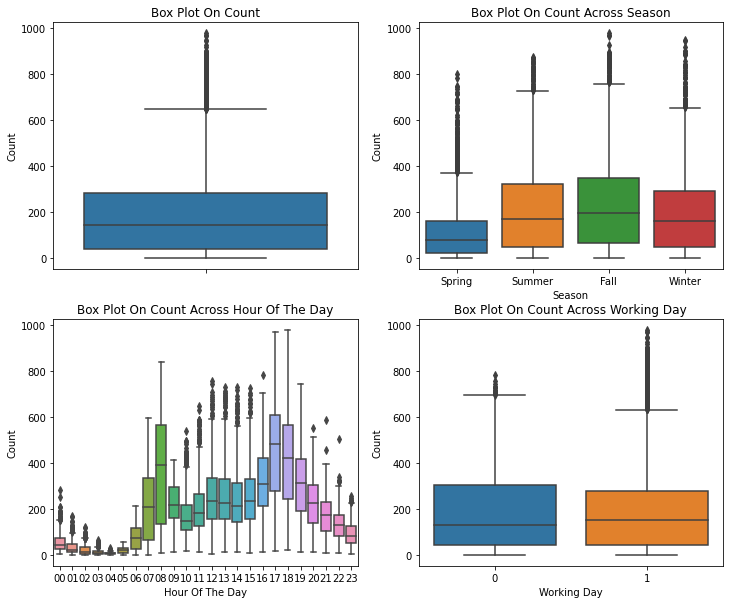

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)

sn.boxplot(data=dailyData, y="count", orient="v", ax=axes[0][0])
sn.boxplot(data=dailyData, y="count", x="season", orient="v", ax=axes[0][1])
sn.boxplot(data=dailyData, y="count", x="hour", orient="v", ax=axes[1][0])
sn.boxplot(data=dailyData, y="count", x="workingday", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel="Count", title="Box Plot On Count")
axes[0][1].set(xlabel="Season", ylabel="Count", title="Box Plot On Count Across Season")
axes[1][0].set(
    xlabel="Hour Of The Day",
    ylabel="Count",
    title="Box Plot On Count Across Hour Of The Day",
)

axes[1][1].set(
    xlabel="Working Day", ylabel="Count", title="Box Plot On Count Across Working Day"
)

In [41]:
# Remove Outliers int the count column
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["count"] - dailyData["count"].mean()) <= (3 * dailyData["count"].std())] 

In [42]:
print ("Shape Of The Before Ouliers: ", dailyData.shape)
print ("Shape Of The After Ouliers: ", dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


<AxesSubplot:>

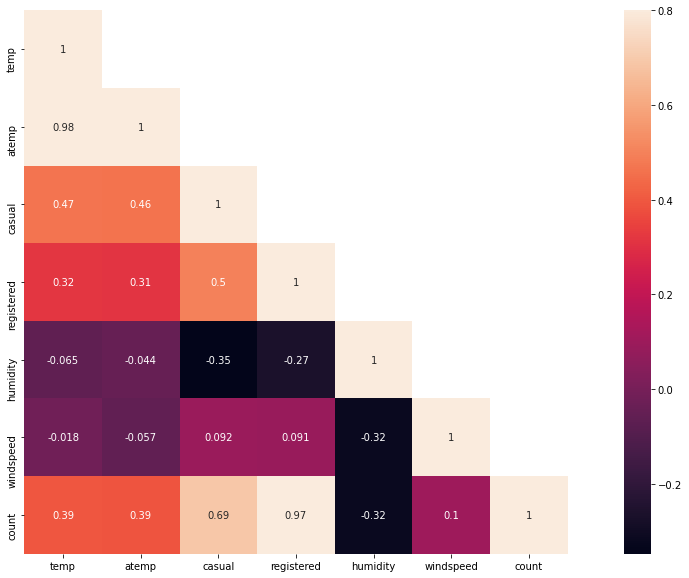

In [47]:
corrMatt = dailyData[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]].corr()

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sn.heatmap(corrMat, mask=mask, vmax=.8, square=True, annot=True)

<AxesSubplot:xlabel='humidity', ylabel='count'>

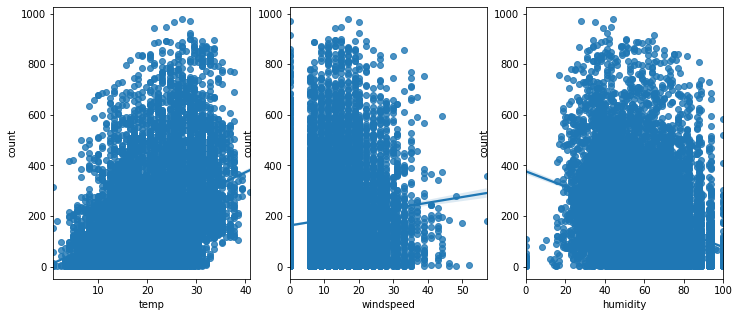

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="count", data=dailyData, ax=ax1)
sn.regplot(x="windspeed", y="count", data=dailyData, ax=ax2)
sn.regplot(x="humidity", y="count", data=dailyData, ax=ax3)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

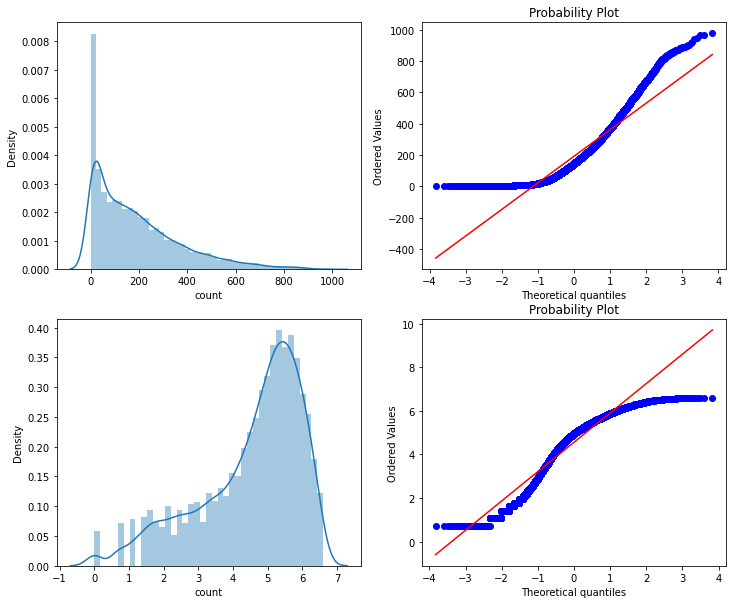

In [51]:
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["count"], ax=axes[0][0])
stats.probplot(dailyData["count"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["count"]), dist="norm", fit=True, plot=axes[1][1])

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, 'Average Users By Hour Of the Day Across User Type'),
 None]

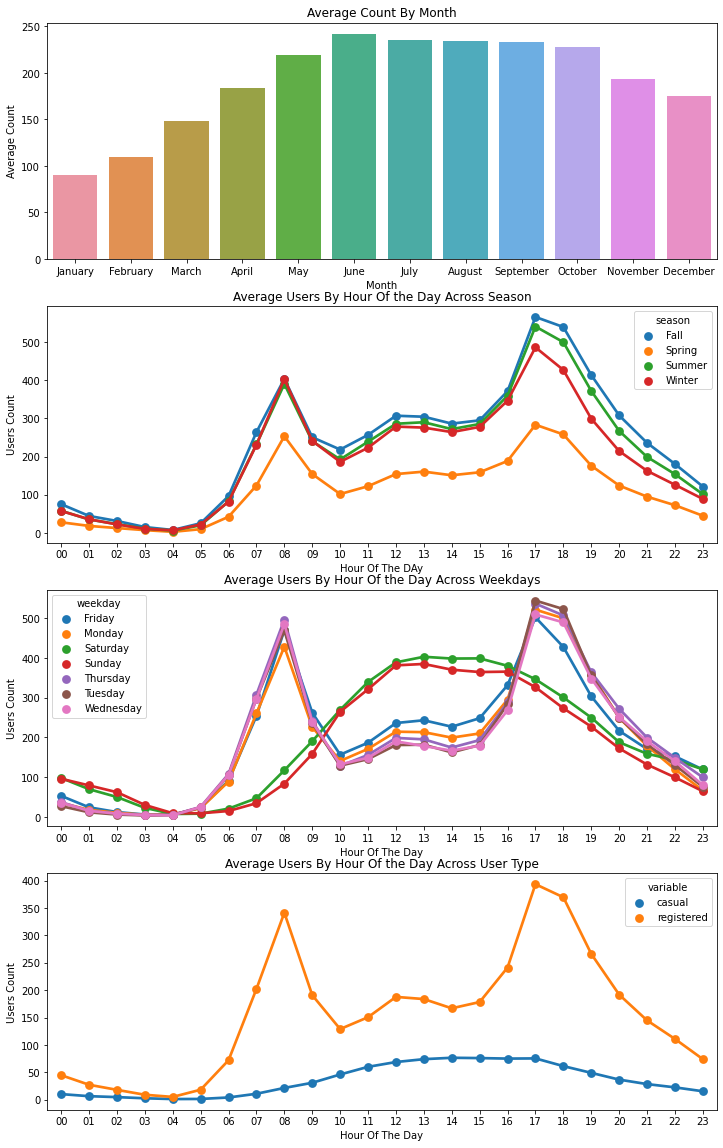

In [58]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4)
fig.set_size_inches(12, 20)
sortOrder = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
hueOrder = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count", ascending=False)
sn.barplot(data=monthSorted, x="month", y="count", ax=ax1, order=sortOrder)
ax1.set(xlabel="Month", ylabel="Average Count", title="Average Count By Month")

hourAggregated = pd.DataFrame(dailyData.groupby(["hour", "season"], sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["season"], data=hourAggregated, join=True, ax=ax2)
ax2.set(xlabel="Hour Of The DAy", ylabel="Users Count", title="Average Users By Hour Of the Day Across Season", label="big")


hourAggregated = pd.DataFrame(dailyData.groupby(["hour", "weekday"], sort=True)["count"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"], hue=hourAggregated["weekday"], data=hourAggregated, join=True, ax=ax3)
ax3.set(xlabel="Hour Of The Day", ylabel="Users Count", title="Average Users By Hour Of the Day Across Weekdays", label="big")

hourTransformed = pd.melt(dailyData[["hour", "casual", "registered"]], id_vars=["hour"], value_vars=["casual", "registered"])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour", "variable"], sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"], hue=hourAggregated["variable"], hue_order=["casual", "registered"], data=hourAggregated, join=True, ax=ax4)
ax4.set(xlabel="Hour Of The Day", ylabel="Users Count", title="Average Users By Hour Of the Day Across User Type", label="big")




## Filling O's In windspeed Using Random Forest

In [59]:
dataTrain = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
dataTest = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

In [60]:
# combine train and test
data = dataTrain.append(dataTest)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

In [61]:
# feature engineering
data["date"] = data.datetime.apply(lambda x: x.split()[0])
data["hour"] = data.datetime.apply(lambda x: x.split()[1].split(":")[0]).astype("int")
data["year"] = data.datetime.apply(lambda x: x.split()[0].split("-")[0])
data["weekday"] = data.date.apply(lambda dateString : datetime.strptime(dateString, "%Y-%m-%d").weekday())
data["month"] = data.date.apply(lambda dateString : datetime.strptime(dateString, "%Y-%m-%d").month)

In [65]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data["windspeed"] == 0]
dataWindNot0 = data[data["windspeed"] != 0]
rfModel_wind = RandomForestRegressor()
windColumns = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])
dataWind0["windspeed"] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1 )

In [67]:
categoricalFeatureNames = ["season","holiday","workingday","weather","weekday","month","year","hour"]
numericalFeatureNames = ["temp","humidity","windspeed","atemp"]
dropFeatures = ['casual',"count","datetime","date","registered"]

In [68]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [69]:
dataTrain = data[pd.notnull(data['count'])].sort_values(by=["datetime"])
dataTest = data[~pd.notnull(data['count'])].sort_values(by=["datetime"])
datetimecol = dataTest["datetime"]
yLabels = dataTrain["count"]
yLabelsRegistered = dataTrain["registered"]
yLAbelsCasual = dataTrain["casual"]

In [70]:
dataTrain = dataTrain.drop(dropFeatures, axis=1)
dataTest = dataTest.drop(dropFeatures, axis=1)

In [79]:
# RMSLE Scorer
def rmsle(y, y_, convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [80]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain, y = yLabelsLog)

# Make predictions
preds = lModel.predict(X=dataTrain)
print("RMSLE Value For Linear Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value For Linear Regression:  0.9779632353656789


{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779632202937973


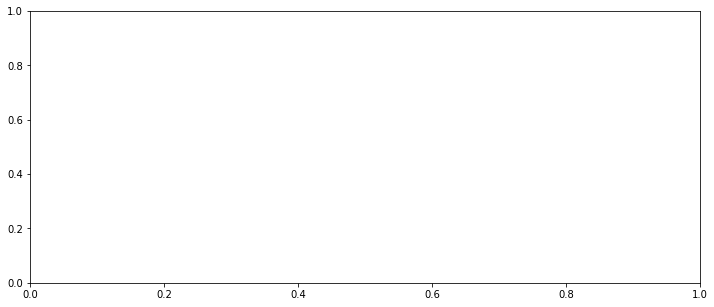

In [89]:
# Regularization Model - Ridge
ridge_m_ = Ridge()
ridge_params_ = {
    'max_iter':[3000],
    'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]
}

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                           ridge_params_,
                           scoring=rmsle_scorer,
                           cv=5)

yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit(dataTrain, yLabelsLog)
preds = grid_ridge_m.predict(X=dataTrain)

print(grid_ridge_m.best_params_)
print("RMSLE Value For Ridge Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
# df = pd.DataFrame(grid_ridge_m.grid_scores_) ??? 안된다
# df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
# df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
# sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [93]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

# fig,ax= plt.subplots()
# fig.set_size_inches(12,5)
# df = pd.DataFrame(grid_ridge_m.grid_scores_)
# df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
# df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
# sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

{'alpha': 0.1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9779632202937973


In [94]:
lasso_m_ = Lasso()

alpha = 1 / np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params_ = {"max_iter": [3000], "alpha": alpha}

grid_lasso_m = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit(dataTrain, yLabelsLog)
preds = grid_lasso_m.predict(X=dataTrain)
print(grid_lasso_m.best_params_)
print("RMSLE Value For Lasso Regression: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False),)

{'alpha': 0.005, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.9781001078026378


In [95]:
from sklearn.ensemble import RandomForestRegressor

rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain, yLabelsLog)
preds = rfModel.predict(X=dataTrain)

print("RMSLE Value For Random Forest: ", rmsle(np.exp(yLabelsLog), np.exp(preds), False))

RMSLE Value For Random Forest:  0.10363741013548815


In [97]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)

yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.18907440501044898


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

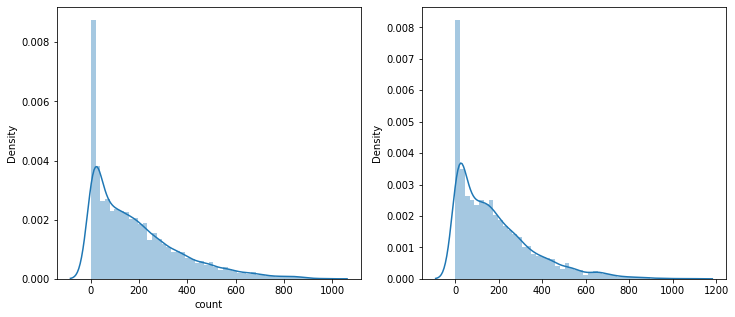

In [98]:
predsTest = gbm.predict(X= dataTest)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)